# "Transfer Learning"
> "How to reuse knowledge infused in a model to perform a similar yet slightly different task"

- toc: false
- branch: master
- badges: true
- comments: true
- categories: [en, ml, raw]
- hide: true
- search_exclude: false


In [1]:
# importing required libraries

from keras.models import Sequential
import cv2
get_ipython().magic('matplotlib inline')
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.layers import Dense
import pandas as pd

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
from keras.applications.vgg16 import decode_predictions

from pathlib import Path
mnist_path = Path("mnist")
img_path = Path("mnist/images/")

## Generate Dataset from scikit learn dataset

In [14]:
from sklearn import datasets
digits = datasets.load_digits()

for i, im in enumerate(digits['images']):
    cv2.imwrite(Path.joinpath(img_path, f"{i}.png").as_posix(),im*16)

(pd.DataFrame({"labels": digits["target"]})
 .to_csv(Path.joinpath(img_path, "labels.csv").as_posix())
)

nb_img = len(list(img_path.glob('*.png')))
limit = int(nb_img*0.75)
train_range = range(limit)
test_range = range(limit, nb_img)
print(nb_img, limit, train_range, test_range)

1797 1347 range(0, 1347) range(1347, 1797)


In [28]:
train_img=[]
for i in train_range:
    temp_img=image.load_img(
        Path.joinpath(img_path, f"{i}.png").as_posix(),
        target_size=(224,224)
    )
    temp_img=image.img_to_array(temp_img)
    train_img.append(temp_img)

#converting train images to array and applying mean subtraction processing

train_img=np.array(train_img)
train_img=preprocess_input(train_img)
# applying the same procedure with the test dataset

test_img=[]
for i in test_range:
    temp_img=image.load_img(
        Path.joinpath(img_path, f"{i}.png").as_posix(),
        target_size=(224,224)
    )
    temp_img=image.img_to_array(temp_img)
    test_img.append(temp_img)

test_img=np.array(test_img)
test_img=preprocess_input(test_img)


(224, 224, 3)


In [95]:
# loading VGG16 model weights
transferred_model = VGG16(weights='imagenet', include_top=False)
transferred_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [17]:
re_extract_features = False
if re_extract_features:
    # Extracting features from the train dataset using the VGG16 pre-trained model
    features_train=transferred_model.predict(train_img)
    # Extracting features from the train dataset using the VGG16 pre-trained model
    features_test=transferred_model.predict(test_img)
else:
    import h5py
    with h5py.File("mnist/mnist_features.hdf5", "r") as f:
        features_train = np.array(f["features/train"])
        features_test = np.array(f["features/test"])
        print(features_train.shape, features_test.shape)

(1347, 7, 7, 512) (450, 7, 7, 512)


### Store the model and the features

In [58]:
features_train.shape, features_test.shape

((1347, 7, 7, 512), (450, 7, 7, 512))

In [52]:
import h5py

In [56]:
with h5py.File("mnist/mnist_features.hdf5", "w") as f:
    dset_train = f.create_dataset("features/train", data=features_train)
    dset_test = f.create_dataset("features/test", data=features_test)

**Note**: Ajouter une phase de mise en évidence des features #explainability

## Adapt features to new MLP

In [21]:
labels = pd.read_csv(Path.joinpath(img_path, "labels.csv").as_posix(), index_col=0)
labels

,labels
0,0
1,1
2,2
3,3
4,4
...,...
1792,9
1793,0
1794,8
1795,9


In [40]:
# flattening the layers to conform to MLP input (N, 7, 7, 512) --> (N, 25088)
train_x=features_train.reshape(features_train.shape[0], 25088)

# converting target variable to array
train_y=labels["labels"].values[train_range]
# performing one-hot encoding for the target variable
train_y=pd.get_dummies(train_y)
train_y=np.array(train_y)
# creating training and validation set
print("Training set", train_x.shape, train_y.shape)

# flattening the layers to conform to MLP input (N, 7, 7, 512) --> (N, 25088)
test_x=features_test.reshape(features_test.shape[0], 25088)

# converting target variable to array
test_y=labels["labels"].values[test_range]
# performing one-hot encoding for the target variable
test_y=pd.get_dummies(test_y)
test_y=np.array(test_y)
# creating testing and validation set
print("Testing set", test_x.shape, test_y.shape)

Training set (1347, 25088) (1347, 10)
Testing set (450, 25088) (450, 10)


## Create the MLP model

In [41]:
from keras.layers import Dense, Activation
model=Sequential()

model.add(Dense(1000, input_dim=25088, activation='relu',kernel_initializer='uniform'))
keras.layers.core.Dropout(0.3, noise_shape=None, seed=None)

model.add(Dense(500,input_dim=1000,activation='sigmoid'))
keras.layers.core.Dropout(0.4, noise_shape=None, seed=None)

model.add(Dense(150,input_dim=500,activation='sigmoid'))
keras.layers.core.Dropout(0.2, noise_shape=None, seed=None)

model.add(Dense(units=10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()

## Train the new model

In [42]:
model.fit(
    train_x,
    train_y,
    epochs=20,
    batch_size=128,
    validation_data=(test_x,test_y),
)

Epoch 1/20
11/11 [==============================] - 2s 117ms/step - loss: 2.3253 - accuracy: 0.1903 - val_loss: 1.8503 - val_accuracy: 0.7089
Epoch 2/20
11/11 [==============================] - 1s 101ms/step - loss: 1.7412 - accuracy: 0.7974 - val_loss: 1.3985 - val_accuracy: 0.8378
Epoch 3/20
11/11 [==============================] - 1s 103ms/step - loss: 1.2646 - accuracy: 0.9024 - val_loss: 0.9943 - val_accuracy: 0.9289
Epoch 4/20
11/11 [==============================] - 1s 103ms/step - loss: 0.8349 - accuracy: 0.9636 - val_loss: 0.6862 - val_accuracy: 0.9378
Epoch 5/20
11/11 [==============================] - 1s 105ms/step - loss: 0.5149 - accuracy: 0.9812 - val_loss: 0.4834 - val_accuracy: 0.9422
Epoch 6/20
11/11 [==============================] - 1s 104ms/step - loss: 0.3083 - accuracy: 0.9904 - val_loss: 0.3589 - val_accuracy: 0.9356
Epoch 7/20
11/11 [==============================] - 1s 101ms/step - loss: 0.1978 - accuracy: 0.9961 - val_loss: 0.2829 - val_accuracy: 0.9489
Epoch 

In [43]:
predict_y = model.predict(test_x)

In [54]:
np.argmax(predict_y, axis=1) == labels.values[test_range]

array([[ True, False,  True, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [ True, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False,  True],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ...,  True, False,  True]])

## Approach 2: append new layers and freeze bottom layers of VGG for training

In [117]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Creating dictionary that maps layer names to the layers
layer_dict = dict([(layer.name, layer) for layer in vgg_model.layers])

# Getting output tensor of the last VGG layer that we want to include
x = layer_dict['block5_pool'].output

# Adding new layers
x = Flatten()(x)
x = Dense(1000, input_dim=25088, activation='relu',kernel_initializer='uniform')(x)
x = keras.layers.core.Dropout(0.3, noise_shape=None, seed=None)(x)
x = Dense(500,input_dim=1000,activation='sigmoid')(x)
x = keras.layers.core.Dropout(0.4, noise_shape=None, seed=None)(x)
x = Dense(150,input_dim=500,activation='sigmoid')(x)
x = keras.layers.core.Dropout(0.2, noise_shape=None, seed=None)(x)
x = Dense(units=10)(x)
x = Activation('softmax')(x)


# Creating new model. Please note that this is NOT a Sequential() model.
from keras.models import Model
custom_model = Model(inputs=vgg_model.input, outputs=x)

# Make sure that the pre-trained bottom layers are not trainable
for layer in custom_model.layers:
    if layer.name in layer_dict:
        layer.trainable = False

# Do not forget to compile it
custom_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [118]:
custom_model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## Train the new model

In [119]:
custom_model.fit(
    train_img,
    train_y,
    epochs=20,
    batch_size=128,
    validation_data=(test_img,test_y),
)

Epoch 1/20
11/11 [==============================] - 122s 11s/step - loss: 2.4470 - accuracy: 0.1130 - val_loss: 2.1486 - val_accuracy: 0.2711
Epoch 2/20
11/11 [==============================] - 136s 13s/step - loss: 2.2192 - accuracy: 0.1839 - val_loss: 1.9199 - val_accuracy: 0.6311
Epoch 3/20
11/11 [==============================] - 129s 12s/step - loss: 1.9635 - accuracy: 0.3612 - val_loss: 1.4907 - val_accuracy: 0.7600
Epoch 4/20
11/11 [==============================] - 128s 12s/step - loss: 1.5639 - accuracy: 0.6354 - val_loss: 1.0121 - val_accuracy: 0.8244
Epoch 5/20
11/11 [==============================] - 128s 12s/step - loss: 1.0947 - accuracy: 0.7856 - val_loss: 0.6528 - val_accuracy: 0.8978
Epoch 6/20
11/11 [==============================] - 618s 61s/step - loss: 0.7248 - accuracy: 0.8800 - val_loss: 0.4142 - val_accuracy: 0.9244
Epoch 7/20
11/11 [==============================] - 124s 12s/step - loss: 0.4343 - accuracy: 0.9431 - val_loss: 0.3164 - val_accuracy: 0.9244
Epoch 

In [123]:
custom_model.save("mnist/custom_model.h5", save_format="h5")

In [ ]:
custom_model = keras.models.load_model("mnist/custom_model.h5")

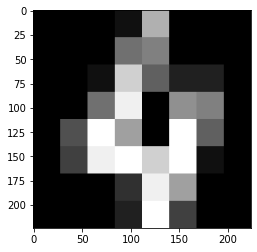

4
---


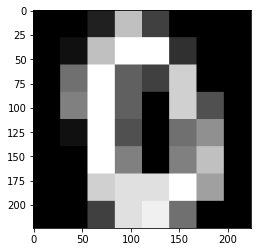

0
---


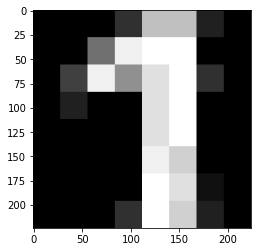

1
---


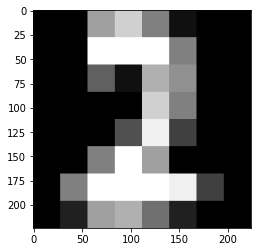

2
---


In [7]:
import matplotlib.pyplot as plt
examples = [4, 150, 1500, 1689]
for ex in examples:
    im = image.load_img(
        Path.joinpath(img_path, f"{ex}.png").as_posix(),
        target_size=(224,224)
    )
    plt.figure()
    plt.imshow(im)
    plt.show()
    y = custom_model.predict(np.array([image.img_to_array(im)]))
    print(np.argmax(y))
    print("---")
